**Introducing BESS**

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [352]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [353]:
os.chdir('/home/MA')

In [354]:
power_balance = pd.read_pickle('Calculations/CH/power_balance_CH.pkl')

Define battery size

In [355]:
battery_size = 72

In [356]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [357]:
eta_discharge = 0.85

Define function for battery dispatch

In [358]:
from Battery_dispatch_function import BatteryDispatch

In [359]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

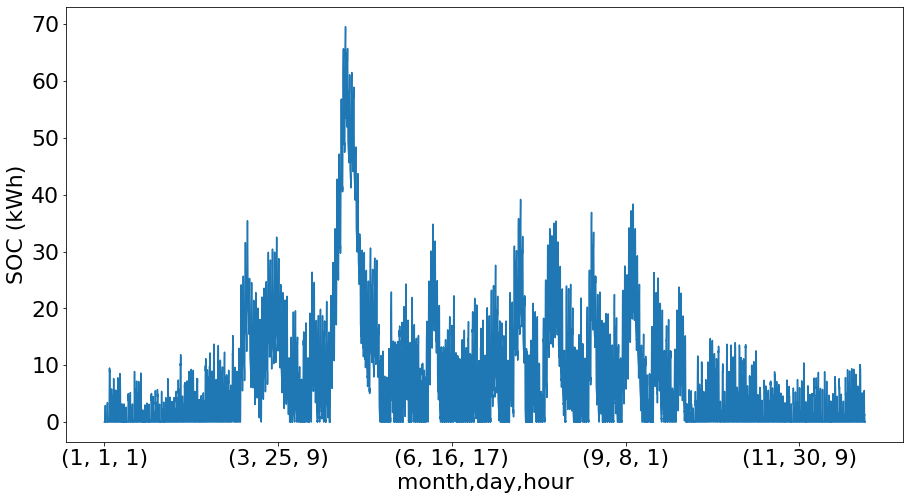

In [360]:
power_balance['SoC'].plot(ylabel = 'SOC (kWh)'); 

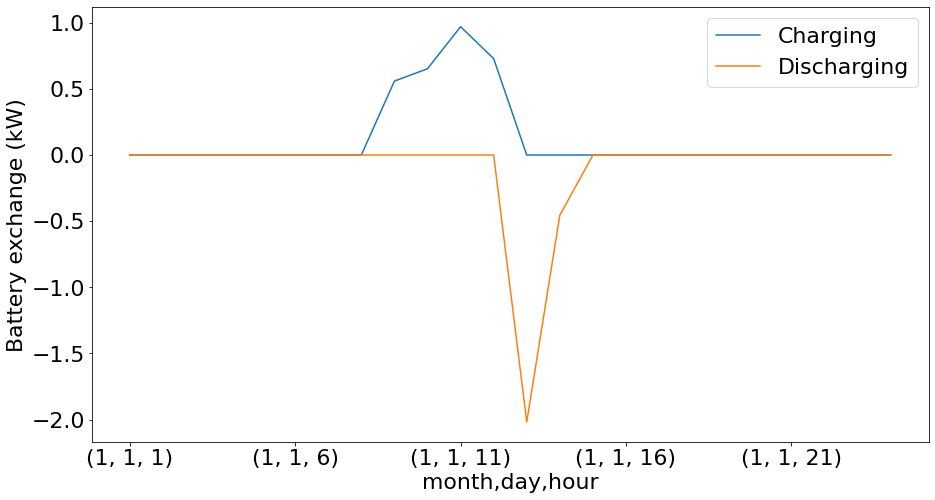

In [361]:
power_balance[['Charging', 'Discharging']].head(24).plot(ylabel = 'Battery exchange (kW)'); 

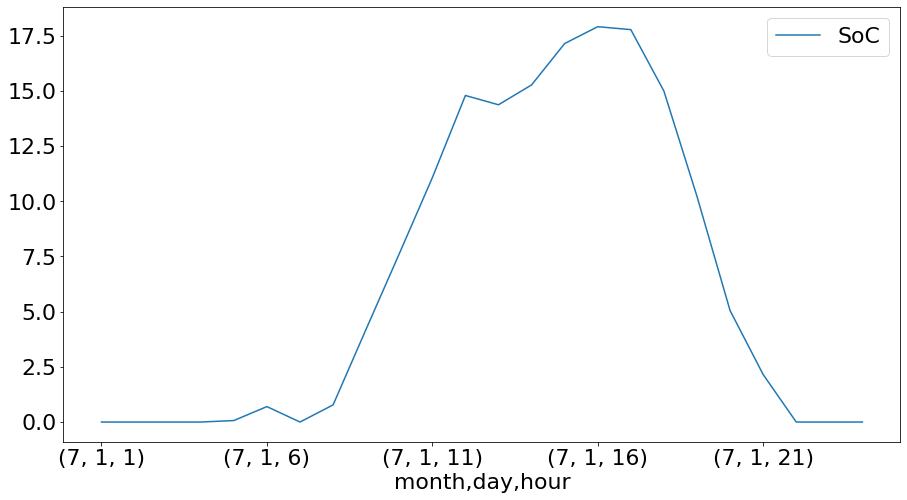

In [362]:
power_balance[['SoC']].iloc[power_balance.index.get_level_values('month') == 7].head(24).plot();

In [363]:
sum(power_balance['Charging'])

5078.085869060647

In [364]:
sum(power_balance['Discharging'])

-4316.372988701597

Check how many cycles were carried out

In [365]:
sum(power_balance['Charging'])/battery_size

70.52897040362011

In [366]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

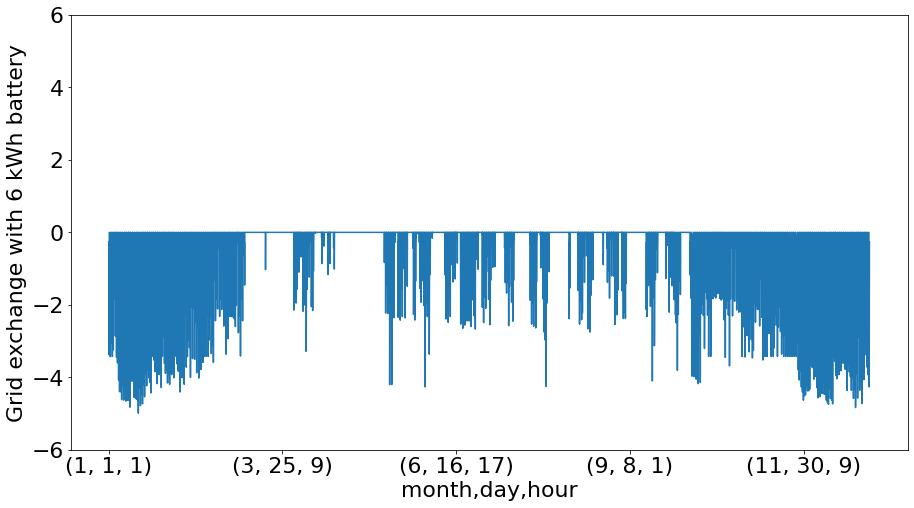

In [367]:
power_balance['exchange grid new'].plot(ylabel = 'Grid exchange with 6 kWh battery', ylim = ([-6, 6]));

Self-consumption share with BESS

In [368]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

0.9113966958677329

Curtailment calculation with BESS

In [369]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

0.0

PV share with BESS

In [370]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.7214246835158911

Losses in the battery system

In [371]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.0886033041322312

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [372]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

-4316.372988701597

**CO$_2$ calculations**

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [374]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [375]:
os.chdir('/home/MA')

In [376]:
PV_lifetime = 25 #years

In [377]:
power_balance = pd.read_pickle('Calculations/CH/power_balance_CH.pkl')

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [378]:
battery_lifetime = 15 # years

In [379]:
grid_emissions_CH= 181.5 # g CO2/kWh

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [380]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [381]:
CO2_intensity_China = 637

In [382]:
battery_size = [0, 6, 12, 18, 24, 72]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [383]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [384]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [385]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_CH / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [386]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [387]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [388]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [389]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [390]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [391]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.590689,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.321059,1970.28,49257,0.357606,8.94015,1432.5,0.912502,8.02765,0.26963
2,12,0.145029,3256.59,81414.8,0.591071,14.7768,2865.0,1.825005,12.9518,0.445659
3,18,0.0414029,4013.83,100346,0.72851,18.2127,4297.5,2.737507,15.4752,0.549286
4,24,0.0163302,4197.04,104926,0.761763,19.0441,5730.0,3.650010,15.3941,0.574359
5,72,0,4316.37,107909,0.783422,19.5855,17190.0,10.950030,8.63551,0.590689


In [392]:
results.set_index("battery_size",drop=True,inplace=True)

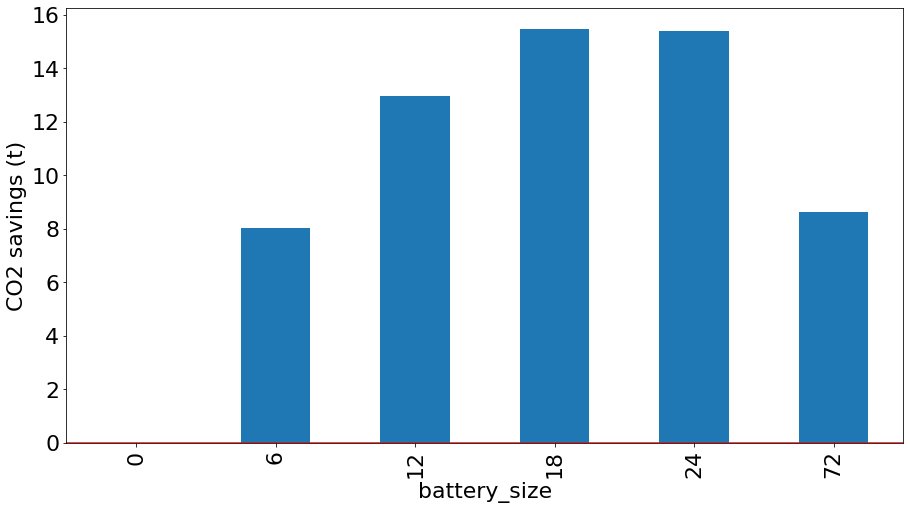

In [393]:
results['net_CO2_savings'].plot.bar(ylabel ='CO2 savings (t)');
plt.axhline(y=0, color='r', linestyle='-')

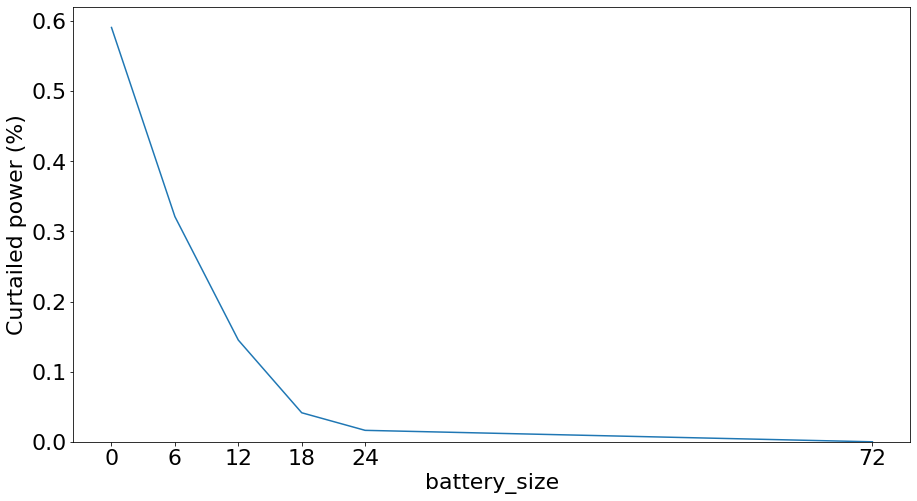

In [394]:
results['curtailment'].plot(xticks = battery_size, ylabel = 'Curtailed power (%)', ylim = ([0, 0.62]));

## EROI calculations

Electricity intensity used for PV production

In [395]:
PV_production_hourly = pd.read_pickle('Calculations/CH/PV_production_CH.pkl')

In [396]:
yearly_PV_production = sum(PV_production_hourly)

In [397]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [398]:
PV_size = 6 #kW_p

In [399]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [400]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [401]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [402]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [403]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [404]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [405]:
results['ESOI'] = results['ESOI'].fillna(0)

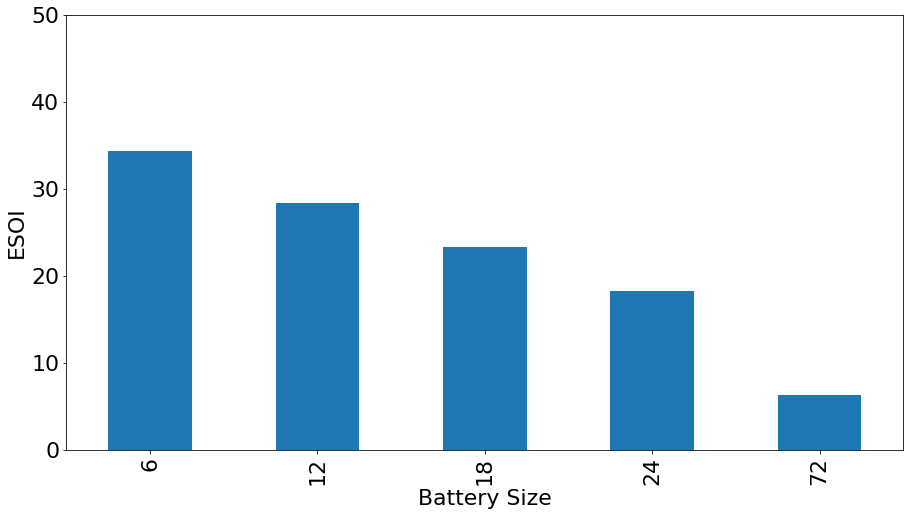

In [406]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI', ylim = ([0, 50]));

In [407]:
results

,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored,total_elec_PV_prod,ESOI,EROI_gen,EROI_grid_useful,EROI_grid_curtailed
battery_size,,,,,,,,,,,,,,
0,0.590689,-0,-0,-0,-0,0.0,0.000000,-0,0,9582,0.000000,22.429791,22.429791,9.180767
6,0.321059,1970.28,49257,0.357606,8.94015,1432.5,0.912502,8.02765,0.26963,9582,34.385351,22.429791,22.429791,12.426932
12,0.145029,3256.59,81414.8,0.591071,14.7768,2865.0,1.825005,12.9518,0.445659,9582,28.417034,22.429791,22.429791,13.238172
18,0.0414029,4013.83,100346,0.72851,18.2127,4297.5,2.737507,15.4752,0.549286,9582,23.349778,22.429791,22.429791,12.915048
24,0.0163302,4197.04,104926,0.761763,19.0441,5730.0,3.650010,15.3941,0.574359,9582,18.311705,22.429791,22.429791,11.835843
72,0,4316.37,107909,0.783422,19.5855,17190.0,10.950030,8.63551,0.590689,9582,6.277448,22.429791,22.429791,6.571916


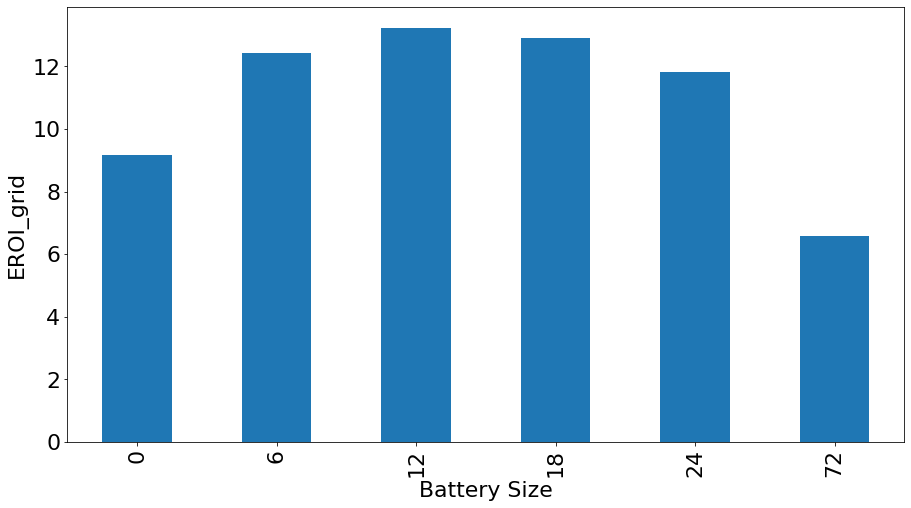

In [408]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');